In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

In [2]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):#fallback string representation
    return f"Value(data={self.data})"
  
  def __add__(self, other):#overload + operator
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other): #overload * operator
    other = other if  isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):  #right-side multiplication
    return self * other
  
  def __pow__(self, other): #overload ** operator
    out = Value(self.data**other, (self, ), f'**{other}')
    
    def _backward():
      self.grad += other * (self.data**(other -1)) * out.grad
    out._backward = _backward
    
    return out
  def __neg__(self):  #overload unary - operator
    return self * Value(-1.0)
  
  def __sub__(self, other):   #overload - operator
    return self + (-other)
  
  def __truediv__(self, other):   #overload / operator
    return self * other**-1
  
  def exp(self):    #exponential function   
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward(): 
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def log(self):  #natural logarithm
    x = self.data
    out = Value(math.log(x), (self, ), 'log')
    
    def _backward():
      self.grad += (1/x) * out.grad
    out._backward = _backward
    
    return out

  def tanh(self):   #hyperbolic tangent function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): #backpropagation
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




$\tanh(x)=\frac{e^{2x}-1}{e^{2x}+1}$

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [47]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
o=((2*y).exp()-1)/((2*y).exp()+1); o.label='o'

In [51]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
oh=y.tanh(); oh.label='oh'

In [48]:
o.backward()

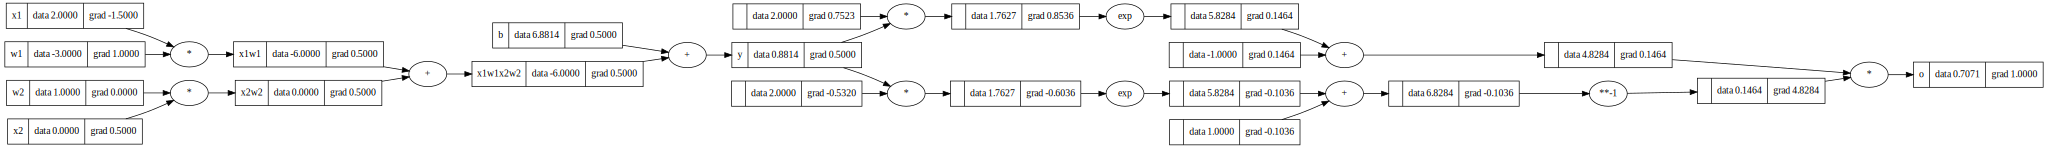

In [49]:
draw_dot(o)

In [52]:
oh.backward()

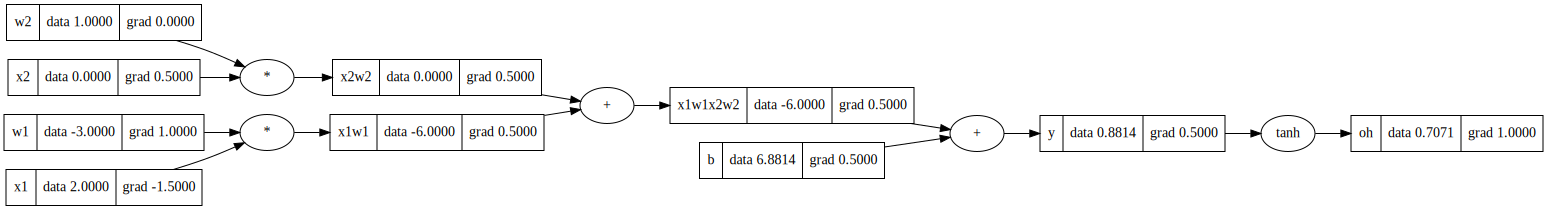

In [53]:
draw_dot(oh)

映射关系的内部延拓不影响原有梯度反向传播结果

In [14]:
%pip install torch


   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB 640.0 kB/s eta 0:02:54
   ---------------------------------------- 0.1/110.9 MB 650.2 kB/s eta 0:02:51
   ---------------------------------------- 0.1/110.9 MB 744.7 kB/s eta 0:02:29
   ---------------------------------------- 0.1/110.9 MB 717.5 kB/s eta 0:02:35
   ---------------------------------------- 0.2/110.9 MB 853.3 kB/s eta 0:02:10
   ---------------------------------------- 0.2/110.9 MB 942.1 kB/s eta 0:01:58
   ---------------------------------------- 0.3/110.9 MB 1.0 MB/s eta 0:01:47
   ---------------------------------------- 0.4/110.9 MB 1.1 MB/s eta 0:01:44
   ---------------------------------------- 0.5/110.9 MB 1.1 MB/s eta 0:01:39
   ---------------------------------------- 0.6/110.9 MB 1.4 MB/s eta 0:01:19
   ---------------------------------------- 0.8/110.9 MB 1.6 MB/s eta 0:01:09
   ---------------------------------------- 1.0/110.9 MB 1.

In [6]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad_(True)
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [16]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [17]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

In [20]:
o.item()

0.7071066904050358

神经网络基本认识[networkDefinition]，我们首先按照下图定义神经元

[networkDefinition]: https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w02/terms.html

![基本神经元数学结构](neuron_model.jpeg "基本神经元数学结构")

In [4]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]#[]用于收集成为列表，作为神经元输入的权重
        self.b = Value(np.random.uniform(-1, 1))#偏置用于控制神经元整体的触发频率
        
    def __call__(self, x):
        #n=n(x)=n.__call__(x)=w*x+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)#self.b作为sum的初始值,可以增加计算效率
        #wi*xi for wi, xi in zip(self.w, x)作为生成器表达式，在python中必须用括号包裹
        out = act.tanh()
        return out
    
    def parameters(self):
        #收集Neuron参数，输出向量格式
        return self.w + [self.b]
    


In [14]:
x=[2.0, 3.0]
n=Neuron(2)
n(x)

Value(data=0.9920468327458113)

In [ ]:
##zip 可以将迭代器整合
print(list(zip([1,2,3], [5,6])))

[(1, 5), (2, 6)]


In [29]:
print(list(zip([1,2,3], [4,5,6])))

[(1, 4), (2, 5), (3, 6)]


In [31]:
print(list(zip([1,2,3], [4,5,6], [7,8,9])))

[(1, 4, 7), (2, 5, 8), (3, 6, 9)]


接下来定义神经层

![基本神经层图连接结构](neuron_Layel.jpg "基本神经层图连接结构")

层结构是独立的神经元的集合

In [5]:
class Layer:
    def __init__(self, nin, nout):
        #初始化层内的每一个独立神经元，根据Neuron的定义，初始参数都是随机的
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        #调用层时，将输入传递给层内的每个神经元（全连接），收集它们的输出
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for Neuron in self.neurons for p in Neuron.parameters()]

In [25]:
n=Layer(2,4)
n(x)

[Value(data=-0.9995484522262122),
 Value(data=0.7757867523457745),
 Value(data=-0.8276486464244194),
 Value(data=-0.9649370753926083)]

接下来将不同层连接起来，组建多层感知器（MLP）

In [26]:
[3]+[1,2,3]

[3, 1, 2, 3]

In [6]:
class MLP:
    def __init__(self, nin, nouts):
        ##这里的nouts是所有Layer中的nout构成的向量。nin是初始层接受的输入向量维度
        ##后续层接受的输入层维度由上一层的nout决定，因此设计sz和Layer(sz[i],sz[i+1])
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        #输入向量在不同层迭代更新
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for Layer in self.layers for p in Layer.parameters()]

In [7]:
T = MLP(3,[4,4,1])
o=[Value(1), Value(2), Value(3)]
T(o)
print(len(T.parameters()))
T.parameters()

41


[Value(data=-0.09511966230965418),
 Value(data=-0.309883942198373),
 Value(data=0.06281772836155564),
 Value(data=-0.08703825078879435),
 Value(data=-0.45145769913952916),
 Value(data=-0.9343289311997971),
 Value(data=-0.6920250384865441),
 Value(data=-0.09519206758107956),
 Value(data=-0.003211909444847505),
 Value(data=0.008377554789513297),
 Value(data=0.5472486163594796),
 Value(data=-0.7556619440060446),
 Value(data=0.16228209208255318),
 Value(data=0.8324955436890316),
 Value(data=0.06907856571086435),
 Value(data=-0.9818815082821049),
 Value(data=-0.6162810208881011),
 Value(data=-0.02850186062399085),
 Value(data=-0.1534684958339243),
 Value(data=0.32650228944605275),
 Value(data=-0.011253786837237767),
 Value(data=0.9994615745934026),
 Value(data=-0.47146187332621103),
 Value(data=-0.8055274492947484),
 Value(data=0.8025961663466104),
 Value(data=0.6619806185918244),
 Value(data=0.3489760986919337),
 Value(data=-0.29018853753375473),
 Value(data=0.9035561369270435),
 Value(dat

In [ ]:
T(o).backward()
draw_dot(T(o))

##注意，这种写法会导致梯度被覆盖，画的图会不对，这是因为，
##T(o).backward()和draw_dot(T(o))本质上是两个T(o)，虽然T的参数没有发生改变(o的输入只调用了T的__call__,没激活初始化，因而没有wi和bi的随机化)
##但是,由于迭代调用__call__,最终会调用到act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)，这里的x就是输入的o
##对于内部的Value类算子来说，xi相当于一个新的输入，因此得到wi*xi是一个新的初始化的Value，其grad为0，第一步的T(o).backward()并没有更新这部分的梯度
##之所以看到部分draw_dot(T(o))部分Value的grad不为0，是因为原有的+self.b并没有重新初始化，因此对应的节点位置grad不为0

In [ ]:
draw_dot(T(o).backward())
##这种调用方式也是错误的，T(o).backward()本身是执行所有向前传播过程的，没有返回值

In [ ]:
# 重要：保存前向传播的输出结果
# 每次调用T(o)都会创建新的计算图（新的Value对象），虽然网络参数相同
# 为了正确进行反向传播和可视化，必须保存并使用同一个输出对象
result = T(o)
result.backward()

In [69]:
result.grad

1.0

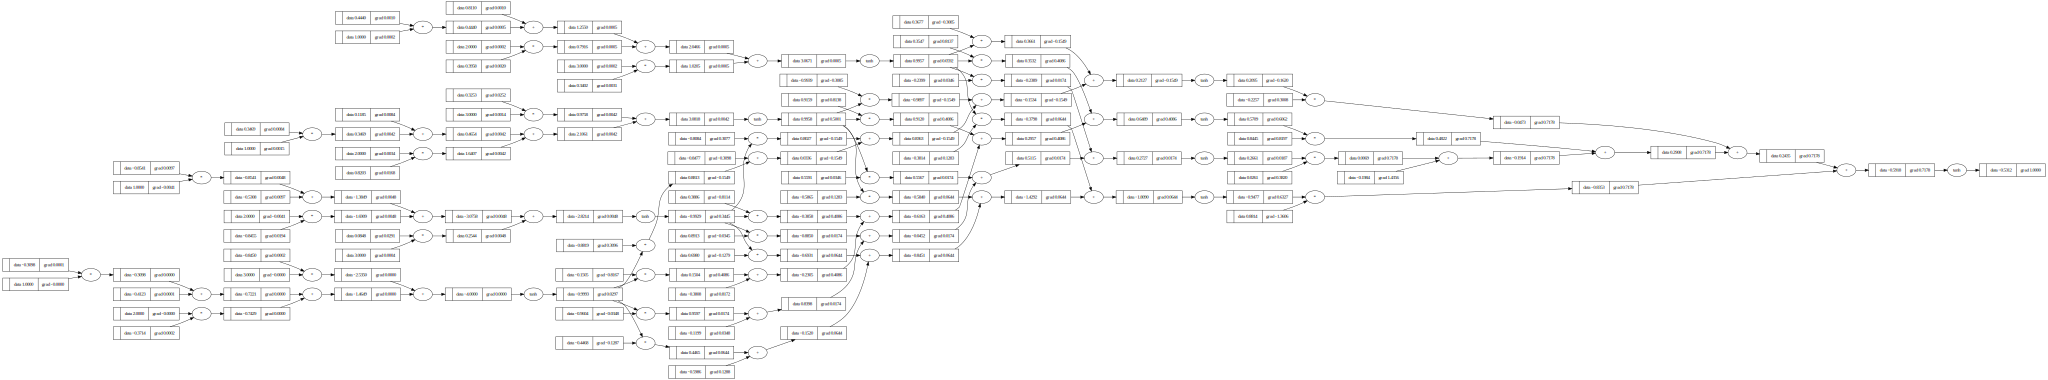

In [70]:
draw_dot(result)

基于以上随机生成的网络，接下来给出我们希望的输入和输出，看看网络的效果

In [109]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]##这是期望输出，看得出来是一个二分类问题
ypred = [T(x) for x in xs]
ypred

[Value(data=-0.9385001089820341),
 Value(data=-0.9285108522814889),
 Value(data=-0.8410333616161643),
 Value(data=-0.9242870228364207)]

In [110]:
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=7.491044309140589)

In [111]:
loss.backward()

In [154]:
T.layers[0].neurons[0].w[0].label='w111'
T.layers[0].neurons[0].w[0].grad

0.006465968006749972

In [ ]:
draw_dot(loss)

In [171]:
for p in T.parameters():
    p.data += -0.01 * p.grad

In [172]:
ypred = [T(x) for x in xs]
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=3.9372408975270843)

In [123]:
x = [2, 5, 6]
T(x)

Value(data=-0.7651986528582986)